<h1 style="color:#1f77b4; text-align:left; font-size:40px;">
    EDA - Exploring Data
</h1>

<h3 style="color:#555; text-align:left;">
    The goal of this exploratory data analysis is to understand behavioral, demographic and service-related patterns associated with customer churn, using only pre-churn and leakage-safe variables.
    EDA is performed on the basic cleaned telco dataset produced in the previous notebook.


</h3>


<h2 style="color:#1f77b4; border-bottom: 3px solid #1f77b4; padding-bottom:4px;">
</h2>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)


# Phase 1 - Introduction & Setup

In [2]:
DATA_PATH = "../data/interim/telco_master_basic_clean.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)

Shape: (7043, 31)


# Phase 2 - Target Distribution & Class Balance

Churn counts:
st_churn_label
No     5174
Yes    1869
Name: count, dtype: int64

Churn proportions:
st_churn_label
No     0.7346
Yes    0.2654
Name: proportion, dtype: float64

Overall churn rate: 26.54%


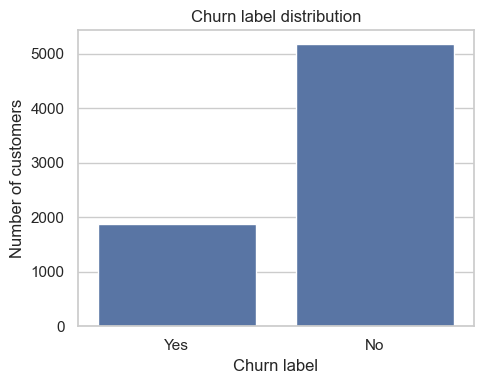

In [3]:
TARGET = "st_churn_label"

# Absolute counts and proportions
target_counts = df[TARGET].value_counts()
target_props = df[TARGET].value_counts(normalize=True).round(4)

print("Churn counts:")
print(target_counts)
print("\nChurn proportions:")
print(target_props)

# Churn rate (Yes)
churn_rate = (df[TARGET] == "Yes").mean()
print(f"\nOverall churn rate: {churn_rate:.2%}")

# Plot class balance
plt.figure(figsize=(5, 4))
sns.countplot(x=TARGET, data=df)
plt.title("Churn label distribution")
plt.ylabel("Number of customers")
plt.xlabel("Churn label")
plt.tight_layout()
plt.show()


# Phase 3 - Demographics vs Churn

In [4]:
# Helpers
def churn_rate_by_category(df, col, target="st_churn_label"):
    temp = (
        df.groupby(col)
        .agg(
            churn_rate=(target, lambda x: (x == "Yes").mean()),
            count=(target, "count")   # número de linhas em cada categoria
        )
        .reset_index()
        #.sort_values("col", ascending=False)
    )
    
    display(temp)
    
    plt.figure(figsize=(7, 4))
    sns.barplot(x=col, y="churn_rate", data=temp, errorbar=None) # with ci=None its putt of the Confidence line on the graph 
    plt.ylabel("Churn rate")
    plt.xlabel(col)
    plt.title(f"Churn rate by {col}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


def plot_distribution(df, col):
    plt.figure(figsize=(7, 4))
    sns.histplot(df[col], bins=30, kde=False)   # ⟵ remove the confidence interval line
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Auxiliary Function to calculate the number of outliers
def count_outliers_IQR(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()


,demo_gender,churn_rate,count
0,Female,0.269209,3488
1,Male,0.261603,3555


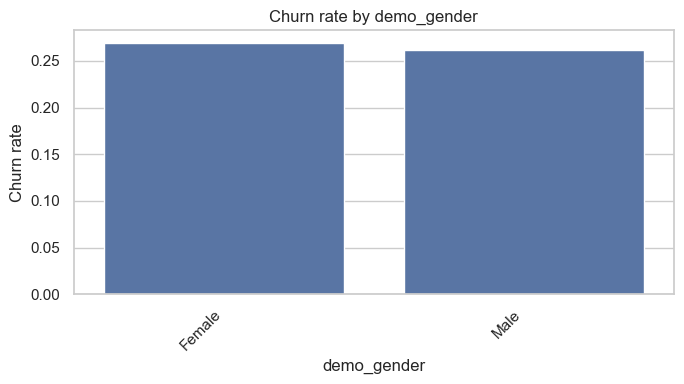

In [5]:
# Gender vs Churn
churn_rate_by_category(df, "demo_gender", TARGET)


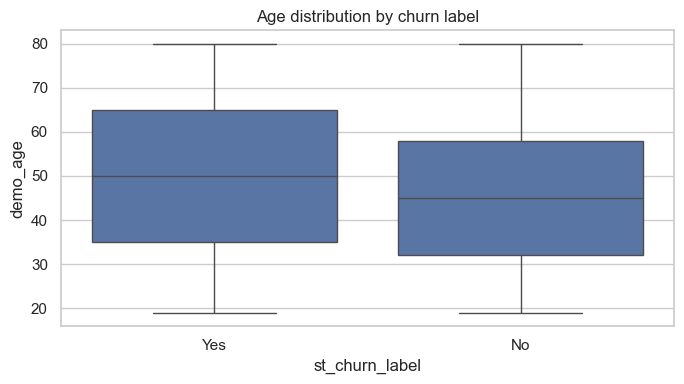

In [6]:
# Age vs Churn
plt.figure(figsize=(7, 4))
sns.boxplot(x=TARGET, y="demo_age", data=df)
plt.title("Age distribution by churn label")
plt.tight_layout()
plt.show()

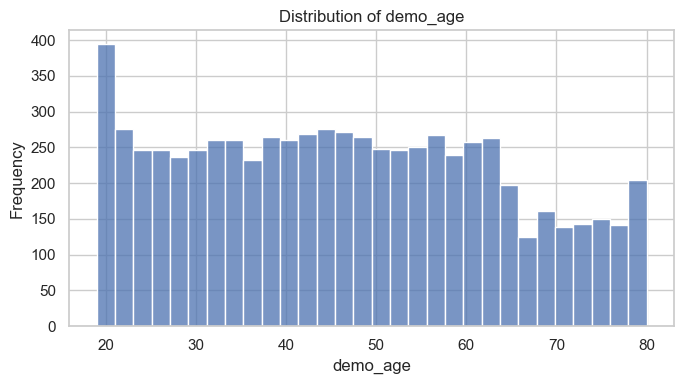

In [7]:
# Distribution of Age
plot_distribution(df, "demo_age")

# Fairly uniform between 20–60 with fewer older customers.

In [8]:
# Age vs Churn
df.groupby(TARGET)["demo_age"].describe()


,count,mean,std,min,25%,50%,75%,max
st_churn_label,,,,,,,,
No,5174.0,45.344414,16.276025,19.0,32.0,45.0,58.0,80.0
Yes,1869.0,49.735688,17.604893,19.0,35.0,50.0,65.0,80.0


,demo_married,churn_rate,count
0,No,0.329580,3641
1,Yes,0.196649,3402


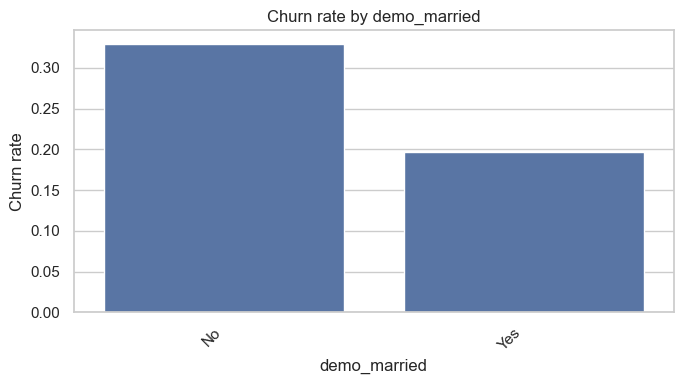

In [9]:
# Married vs Churn
churn_rate_by_category(df, "demo_married", TARGET)


,demo_number_of_dependents,churn_rate,count
0,0,0.325517,5416
1,1,0.068716,553
2,2,0.062147,531
3,3,0.058027,517
4,4,0.111111,9
5,5,0.200000,10
6,6,0.333333,3
7,7,0.500000,2
8,8,0.000000,1
9,9,0.000000,1


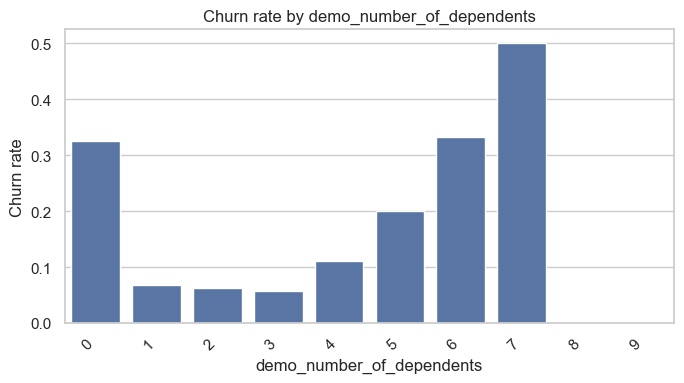

In [10]:
# Dependents vs Churn
churn_rate_by_category(df, "demo_number_of_dependents", TARGET)


**Demographic Insights Summary**

Demographic effects on churn are clear and structured:

- **Customers with dependents**: rate varies  across the number of dependents, showing a U-shaped pattern. Customers with no dependents and very large households exhibit the highest churn, while those with 1–3 dependents are the most stable. 
- **Married customers** show lower churn than non-married customers.
- **Gender** has no meaningful impact on churn.
- **Age** shows only a mild effect on churn.

These results indicate that **life-stage stability** is a key demographic driver of churn.


# Phase 4 - Contract and Billing vs Churn

,svc_contract,churn_rate,count
0,Month-to-Month,0.458449,3610
1,One Year,0.107097,1550
2,Two Year,0.025491,1883


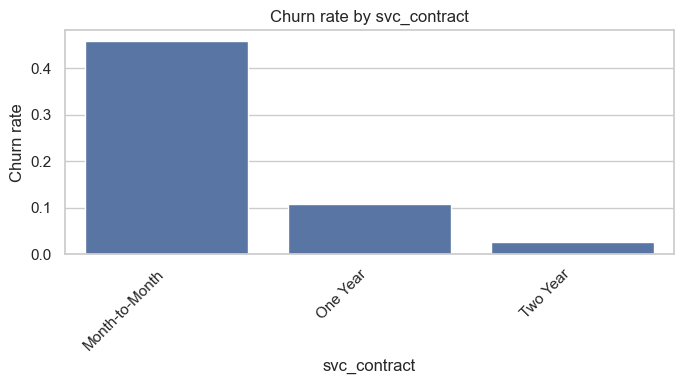

In [11]:
# Contract vs Churn
churn_rate_by_category(df, "svc_contract", TARGET)


,svc_paperless_billing,churn_rate,count
0,No,0.163301,2872
1,Yes,0.335651,4171


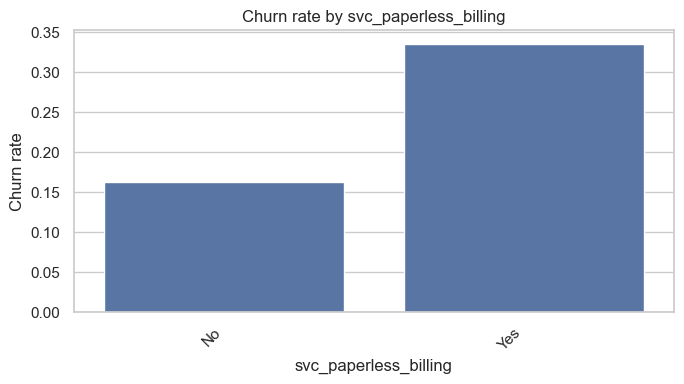

In [12]:
# Paperless Billing vs Churn
churn_rate_by_category(df, "svc_paperless_billing", TARGET)


In [13]:
# This pattern is likely partly explained by correlation with Month-to-Month contracts(customers signing up online with more flexible plans) 
# rather than paperless billing itself being the direct cause of churn.

pd.crosstab(
    df['svc_paperless_billing'],
    df['svc_contract'],
    normalize='index'
)

svc_contract,Month-to-Month,One Year,Two Year
svc_paperless_billing,,,
No,0.425487,0.241295,0.333217
Yes,0.572525,0.205466,0.222009


,svc_payment_method,churn_rate,count
0,Bank Withdrawal,0.339985,3909
1,Credit Card,0.144780,2749
2,Mailed Check,0.368831,385


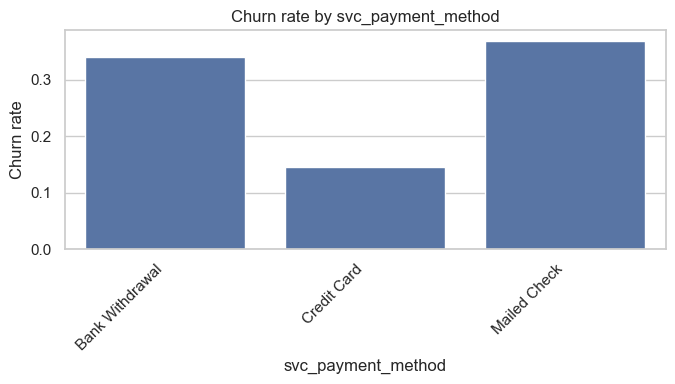

In [14]:
# Payment Method vs Churn
churn_rate_by_category(df, "svc_payment_method", TARGET)


In [15]:
# Churn varies substantially across payment methods: 
#   mailed check and bank withdrawal customers exhibiting the highest churn, 
#   while credit card users show the lowest churn. 

# Since payment method is strongly associated with contract structure, a conditional analysis by both payment method and contract type is required
# Goal: determine whether this effect is intrinsic or primarily driven by the prevalence of Month-to-Month contracts.

pd.crosstab(
    df['svc_payment_method'],
    df['svc_contract'],
    normalize='index'
)

svc_contract,Month-to-Month,One Year,Two Year
svc_payment_method,,,
Bank Withdrawal,0.573037,0.203888,0.223075
Credit Card,0.413241,0.244089,0.342670
Mailed Check,0.607792,0.212987,0.179221


In [16]:
# Month-to-Month contracts have the highest churn across all payment methods
# This confirms that contract type is the dominant driver of churn.

# However, payment method STILL adds information inside Month-to-Month:
#   Credit Card (0.413) < Bank Withdrawal (0.573) < Mailed Check (0.608)

# svc_payment_method is not just a proxy for contract type — it has a real secondary behavioral effect, especially within the high-risk Month-to-Month group.

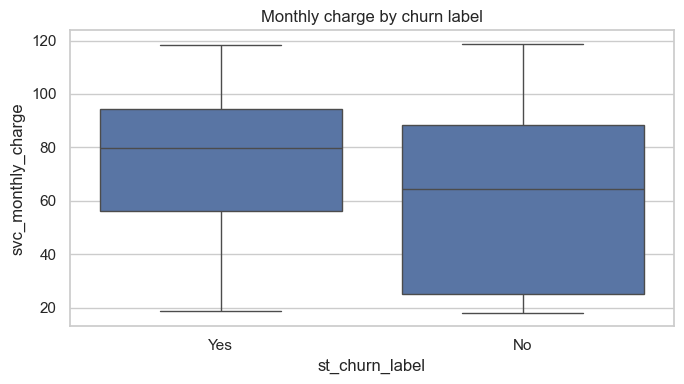

,count,mean,std,min,25%,50%,75%,max
st_churn_label,,,,,,,,
No,5174.0,61.265124,31.092648,18.25,25.10,64.425,88.4,118.75
Yes,1869.0,74.441332,24.666053,18.85,56.15,79.650,94.2,118.35


In [17]:
# Monthly Charge vs Churn
plt.figure(figsize=(7, 4))
sns.boxplot(x=TARGET, y="svc_monthly_charge", data=df)
plt.title("Monthly charge by churn label")
plt.tight_layout()
plt.show()

df.groupby(TARGET)["svc_monthly_charge"].describe()


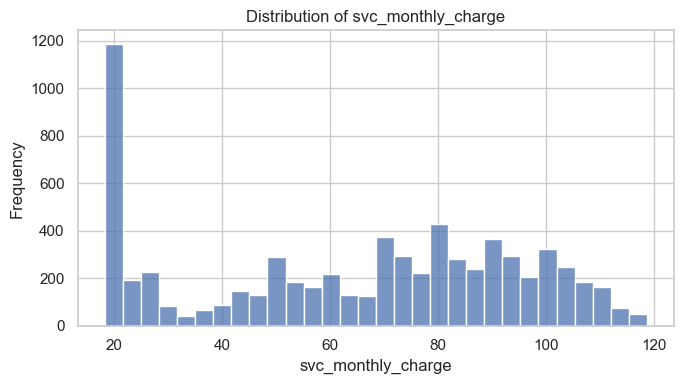

In [18]:
# Distribution of Monthly Charge
plot_distribution(df, "svc_monthly_charge")


,svc_offer,churn_rate,count
0,No Offer,0.271086,3877
1,Offer A,0.067308,520
2,Offer B,0.122573,824
3,Offer C,0.228916,415
4,Offer D,0.267442,602
5,Offer E,0.529193,805


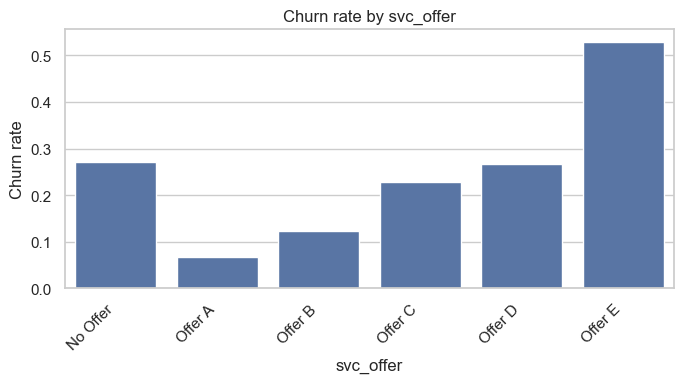

In [19]:
# Offer vs Churn
churn_rate_by_category(df, "svc_offer", TARGET)

In [20]:
df.groupby("svc_offer")["svc_monthly_charge"].describe()


,count,mean,std,min,25%,50%,75%,max
svc_offer,,,,,,,,
No Offer,3877.0,64.355791,29.979067,18.75,35.2000,70.20,89.6000,118.75
Offer A,520.0,77.719519,31.113157,19.10,58.9875,85.30,104.4500,118.65
Offer B,824.0,70.829976,30.852741,18.40,45.8875,79.35,97.9625,118.60
Offer C,415.0,66.578313,29.390068,18.25,40.6250,74.75,90.9000,116.25
Offer D,602.0,58.168937,28.635499,18.80,24.8500,60.40,83.7875,112.95
Offer E,805.0,56.128509,26.162345,18.80,29.0500,55.55,78.9500,109.90


In [21]:
# Monthly charges vary substantially across promotional offers.  
# Offers A, B, and C are associated with higher median monthly charges - they target premium service bundles. 
# In contrast, Offers D and E show lower median prices representing true discount-oriented segments.

# This confirms that promotional offers act primarily as customer segmentation mechanisms not merely as price reductions. 
# As a result, the observed churn differences across offers reflect both pricing effects and structural differences in customer profiles

### Contract & Billing Insights Summary

Contractual and billing characteristics show some of the **strongest churn patterns** in the dataset:

- **Month-to-Month** contracts are highly unstable and strongly associated with churn, while **long-term contracts** (especially Two Year) are extremely stable.
- **Paperless billing** is associated with higher churn, likely because it correlates with more flexible, online-driven contracts rather than being causal by itself.
- **Payment method** matters: customers paying by **Credit Card** churn much less than those paying by **Mailed Check** or **Bank Withdrawal**.
- **Higher monthly charges** are associated with higher churn, reinforcing the role of **price sensitivity** in customer attrition.
- **Promotional offers act as segmentation mechanisms rather than simple discounts**:  
  - Offers **A, B, and C** target **higher-paying, premium customers**,  
  - Offers **D and E** correspond to **lower-priced, discount-oriented segments**,  
  - while **“No Offer”** customers sit in an intermediate price tier.  
  This explains why churn rates differ across offers due to both **pricing and structural customer differences**.

Together, these findings indicate that **contract structure, pricing level, promotional strategy, and billing/payment setup** are key levers for churn management.


# Phase 5 - Services & Add-ons vs Churn


,svc_phone_service,churn_rate,count
0,No,0.249267,682
1,Yes,0.267096,6361


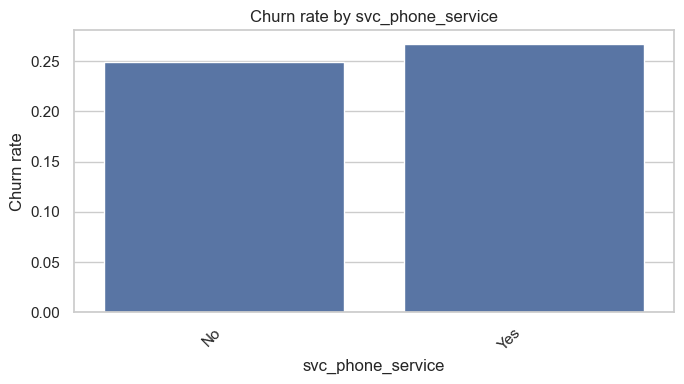

In [22]:
# Phone Service vs Churn
churn_rate_by_category(df, "svc_phone_service", TARGET)


,svc_multiple_lines,churn_rate,count
0,No,0.250246,4072
1,Yes,0.286099,2971


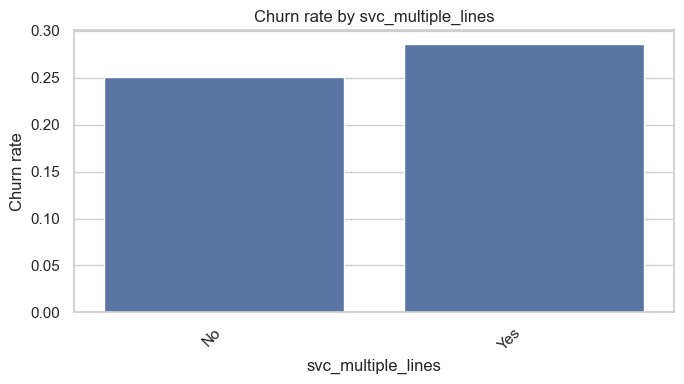

In [23]:
# Multiple Lines vs Churn
churn_rate_by_category(df, "svc_multiple_lines", TARGET)

,svc_internet_service,churn_rate,count
0,No,0.074050,1526
1,Yes,0.318289,5517


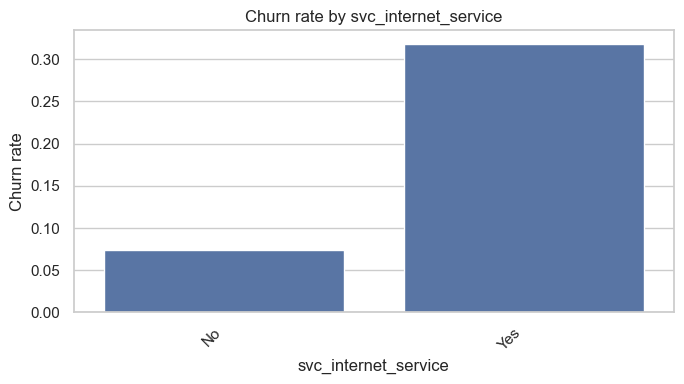

In [24]:
# Internet Service vs Churn
churn_rate_by_category(df, "svc_internet_service", TARGET)

,svc_internet_type,churn_rate,count
0,Cable,0.256627,830
1,DSL,0.185835,1652
2,Fiber Optic,0.407249,3035
3,No Internet,0.074050,1526


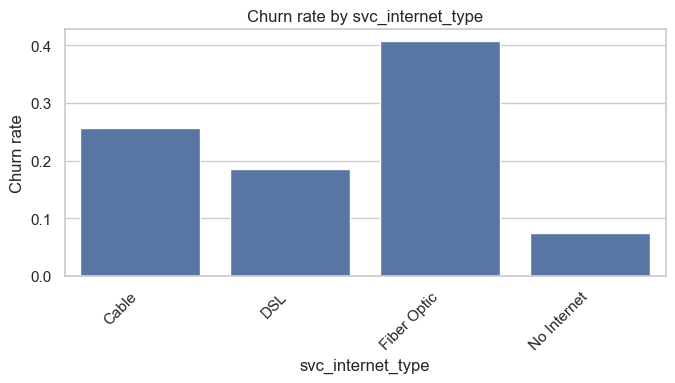

In [25]:
# Internet Type vs Churn
churn_rate_by_category(df, "svc_internet_type", TARGET)

,svc_online_security,churn_rate,count
0,No,0.313296,5024
1,Yes,0.146112,2019


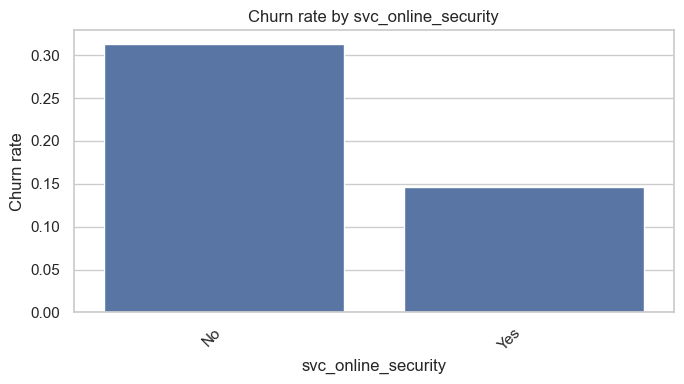

In [26]:
# Online Security vs Churn
churn_rate_by_category(df, "svc_online_security", TARGET)

,svc_online_backup,churn_rate,count
0,No,0.291721,4614
1,Yes,0.215315,2429


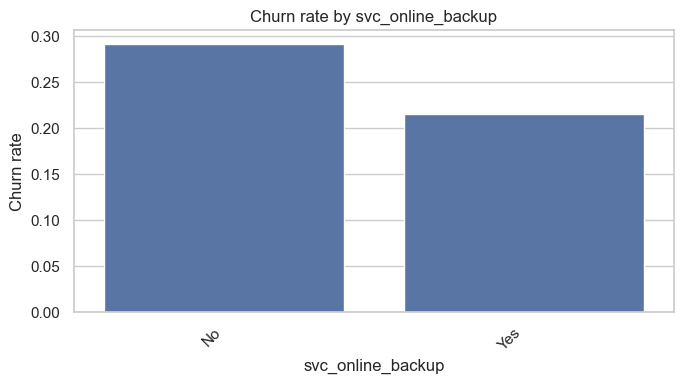

In [27]:
# Online Backup vs Churn
churn_rate_by_category(df, "svc_online_backup", TARGET)

,svc_device_protection_plan,churn_rate,count
0,No,0.286518,4621
1,Yes,0.225021,2422


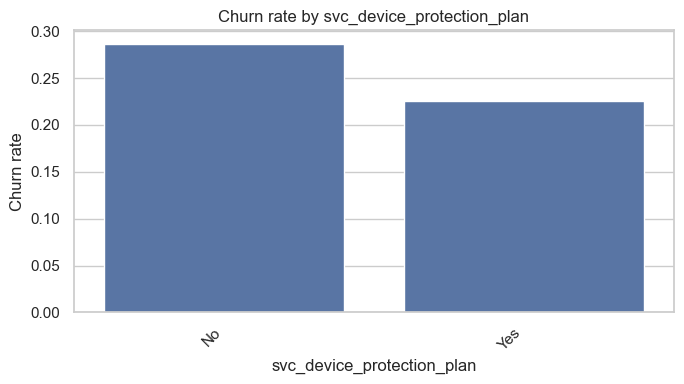

In [28]:
# Service Protection Plan vs Churn
churn_rate_by_category(df, "svc_device_protection_plan", TARGET)

,svc_premium_tech_support,churn_rate,count
0,No,0.311862,4999
1,Yes,0.151663,2044


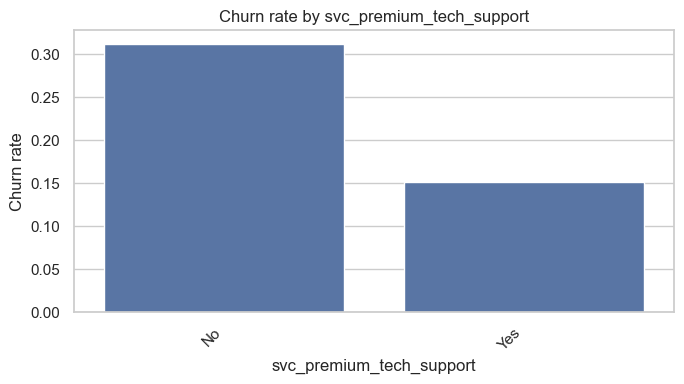

In [29]:
# Premium Tech Support vs Churn
churn_rate_by_category(df, "svc_premium_tech_support", TARGET)


,svc_streaming_tv,churn_rate,count
0,No,0.243312,4336
1,Yes,0.300702,2707


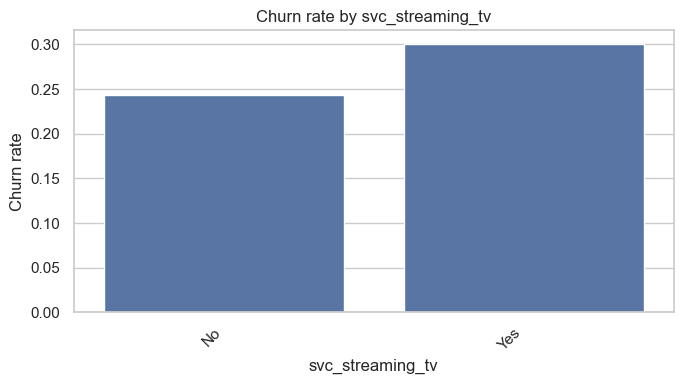

,svc_streaming_movies,churn_rate,count
0,No,0.243795,4311
1,Yes,0.299414,2732


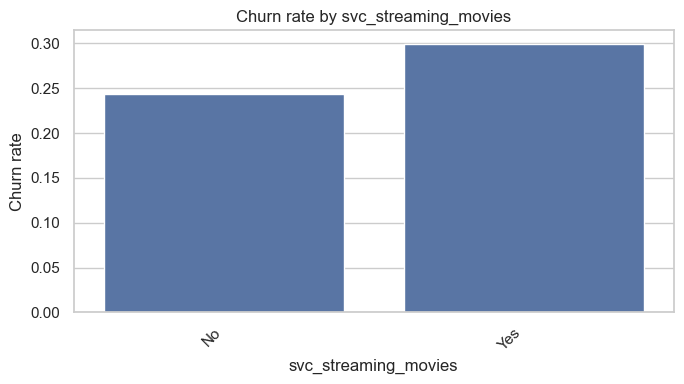

,svc_streaming_music,churn_rate,count
0,No,0.250494,4555
1,Yes,0.292605,2488


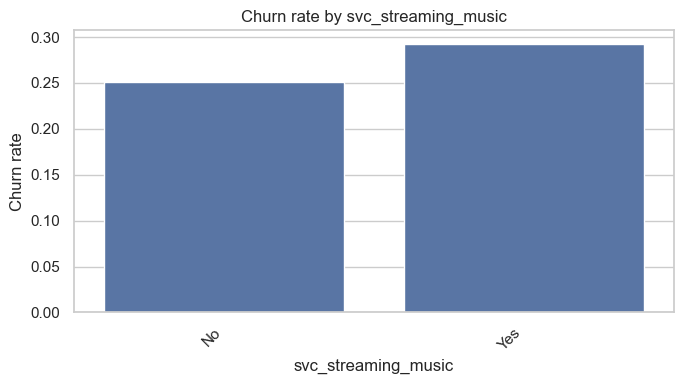

In [30]:
# Streaming Services vs Churn
churn_rate_by_category(df, "svc_streaming_tv", TARGET)
churn_rate_by_category(df, "svc_streaming_movies", TARGET)
churn_rate_by_category(df, "svc_streaming_music", TARGET)


,svc_unlimited_data,churn_rate,count
0,No,0.159704,2298
1,Yes,0.316544,4745


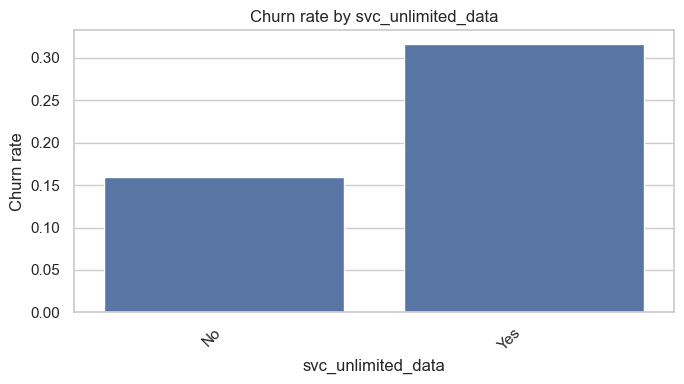

In [31]:
# Unlimited Data vs Churn
churn_rate_by_category(df, "svc_unlimited_data", TARGET)


,svc_referred_a_friend,churn_rate,count
0,No,0.325831,3821
1,Yes,0.193669,3222


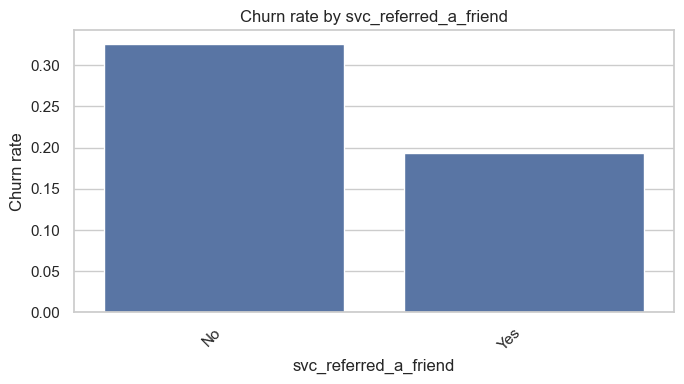

In [32]:
# Refered a Friend vs Churn
churn_rate_by_category(df, "svc_referred_a_friend", TARGET)


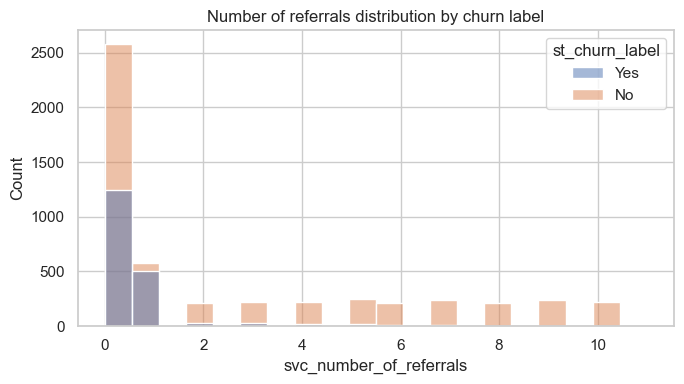

In [33]:
# Number of referals vs Churn
plt.figure(figsize=(7, 4))
sns.histplot(data=df, x="svc_number_of_referrals", hue=TARGET, bins=20, kde=False)
plt.title("Number of referrals distribution by churn label")
plt.tight_layout()
plt.show()



### Services & Add-ons Insights Summary

Clear and consistent patterns emerge from the service-level analysis:

- **Online security, online backup, device protection, and premium tech support** are all associated with **substantially lower churn**, acting as strong **protective retention factors**.
- **Internet service customers**, particularly those using **fiber optic**, exhibit **significantly higher churn**, reflecting stronger competition and greater price sensitivity in premium connectivity.
- **Streaming services** (TV, movies, and music) display **only weak to moderate effects** on churn and appear to be **secondary contributors**.
- **Unlimited data plans** are linked to **higher churn**, likely reflecting the behavior of **high-usage and price-sensitive customers**.
- **Referral behavior strengthens retention**: customers who referred friends and those with a higher number of referrals show **significantly lower churn**, indicating that **social engagement and brand advocacy are strong loyalty signals**.

Overall, **value-added protection, support services, and social engagement act as key stabilizers**, while **high-speed, high-usage services remain more volatile and churn-prone**.


# Phase 6 - Numeric Behavioral Drivers vs Churn


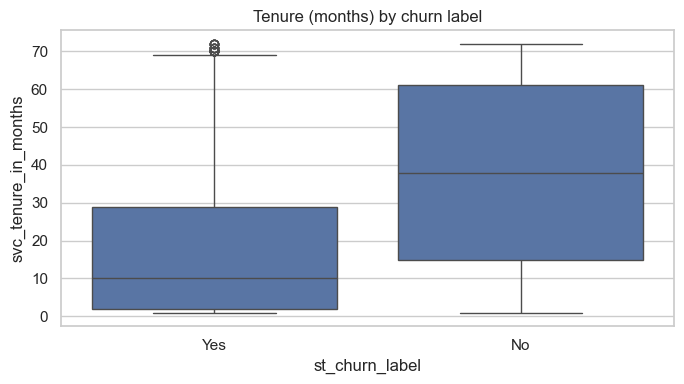

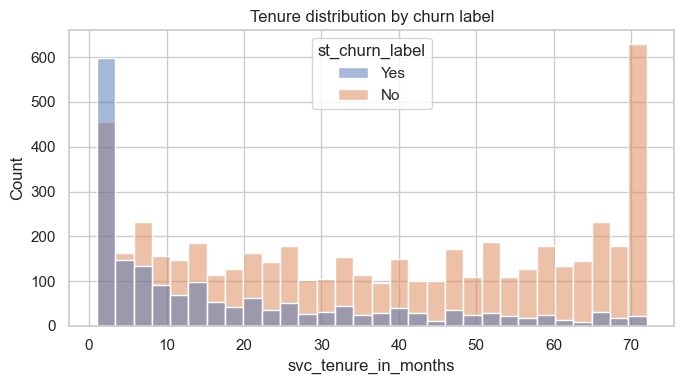

,count,mean,std,min,25%,50%,75%,max
st_churn_label,,,,,,,,
No,5174.0,37.591225,24.085029,1.0,15.0,38.0,61.0,72.0
Yes,1869.0,17.979133,19.531123,1.0,2.0,10.0,29.0,72.0


In [42]:
# Tenure vs Churn
plt.figure(figsize=(7, 4))
sns.boxplot(x=TARGET, y="svc_tenure_in_months", data=df)
plt.title("Tenure (months) by churn label")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
sns.histplot(data=df, x="svc_tenure_in_months", hue=TARGET, bins=30, kde=False)
plt.title("Tenure distribution by churn label")
plt.tight_layout()
plt.show()

df.groupby(TARGET)["svc_tenure_in_months"].describe()





In [35]:
outlier_counts = df.groupby(TARGET)["svc_tenure_in_months"].apply(count_outliers_IQR)
outlier_counts


st_churn_label
No      0
Yes    23
Name: svc_tenure_in_months, dtype: int64

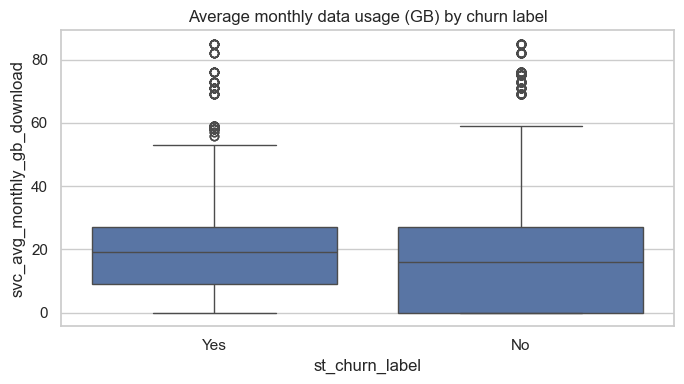

,count,mean,std,min,25%,50%,75%,max
st_churn_label,,,,,,,,
No,5174.0,22.883572,15.462845,0.0,9.1,22.89,36.4175,49.99
Yes,1869.0,23.167635,15.409464,0.0,9.5,22.88,36.3600,49.98


In [36]:
# Monthly Data Usage vs Churn
plt.figure(figsize=(7, 4))
sns.boxplot(x=TARGET, y="svc_avg_monthly_gb_download", data=df)
plt.title("Average monthly data usage (GB) by churn label")
plt.tight_layout()
plt.show()

df.groupby(TARGET)["svc_avg_monthly_long_distance_charges"].describe()


In [37]:
outlier_counts = df.groupby(TARGET)["svc_avg_monthly_gb_download"].apply(count_outliers_IQR)
outlier_counts


st_churn_label
No     278
Yes    147
Name: svc_avg_monthly_gb_download, dtype: int64

C:\Users\sergi\AppData\Local\Temp\ipykernel_28408\4260977667.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


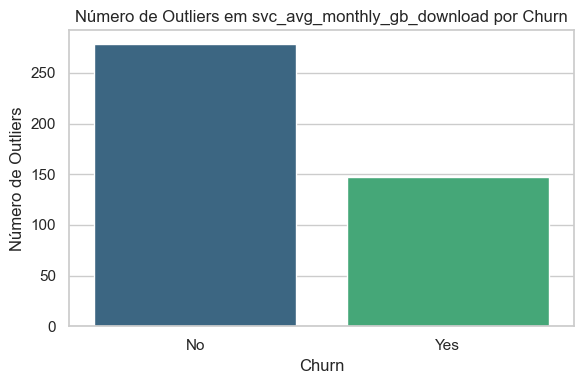

In [38]:
plt.figure(figsize=(6,4))
sns.barplot(
    x=outlier_counts.index,
    y=outlier_counts.values,
    palette="viridis"
)

plt.title("Número de Outliers em svc_avg_monthly_gb_download por Churn")
plt.xlabel("Churn")
plt.ylabel("Número de Outliers")
plt.tight_layout()
plt.show()


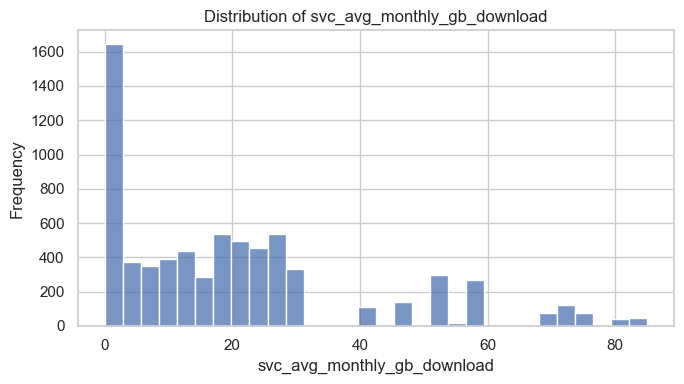

In [39]:
# Distribution of Monthly Usage
plot_distribution(df, "svc_avg_monthly_gb_download")


In [40]:
""""
plt.figure(figsize=(7, 4))
sns.boxplot(x=TARGET, y="zip_population", data=df)
plt.title("Zipcode population by churn label")
plt.tight_layout()
plt.show()

df.groupby(TARGET)["zip_population"].describe()
"""

'"\nplt.figure(figsize=(7, 4))\nsns.boxplot(x=TARGET, y="zip_population", data=df)\nplt.title("Zipcode population by churn label")\nplt.tight_layout()\nplt.show()\n\ndf.groupby(TARGET)["zip_population"].describe()\n'

**Numeric Behavioral Drivers Insights Summary**

Clear numeric patterns emerge:

- **Tenure** is the strongest continuous driver of churn: customers with short tenure are far more likely to churn.
- **Higher data usage** and **higher long-distance charges** are associated with slightly higher churn, reflecting price sensitivity under heavier usage.
- **Local population size** show only weak to moderate effects compared to behavioral and contractual variables.

Overall, **customer lifetime and usage intensity are far more informative than static demographic context**.


# Phase 7 - Correlation Analysis 


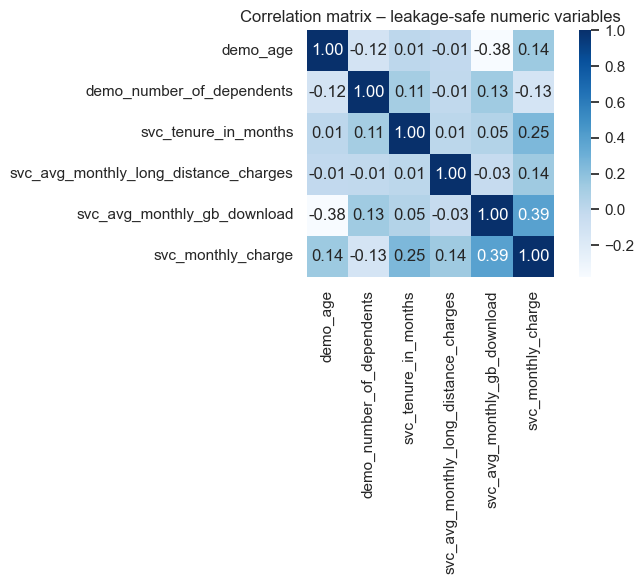

In [41]:
# The correlation matrix should show low to moderate correlations to confirm there are no severe multicollinearity risks

numeric_valid = [
    "demo_age",
    "demo_number_of_dependents",
    "svc_tenure_in_months",
    "svc_avg_monthly_long_distance_charges",
    "svc_avg_monthly_gb_download",
    "svc_monthly_charge"
]

corr = df[numeric_valid].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues", square=True)
plt.title("Correlation matrix – leakage-safe numeric variables")
plt.tight_layout()
plt.show()


### Business Implications: From EDA to Modeling

The EDA confirms that churn in this dataset is driven by a **small, well-defined set of structural and behavioral factors**:

- **Contract type and tenure** are the strongest churn drivers, with extreme instability among Month-to-Month and early-lifecycle customers.
- **Pricing and billing behavior** (monthly charges, payment method, paperless billing) reflect strong **price sensitivity and automation effects**.
- **Protective services and customer support** (security, backup, tech support, device protection) act as powerful **retention stabilizers**.
- **High-speed internet usage, unlimited data, and fiber plans** are associated with higher churn due to **competitive pressure and premium price sensitivity**.
- **Customer engagement through referrals** is one of the strongest **loyalty signals**, while **demographic stability** (dependents, marital status) reduces churn risk.

All **post-outcome and cumulative financial variables were excluded** to prevent target leakage, and the remaining numeric features show **low multicollinearity**, ensuring a **leakage-safe and model-ready feature space**.

### Implication for Modeling

These findings directly inform the modeling strategy:
- Emphasis on **contract, tenure, pricing, service adoption, billing, and referral features**.
- Support for **non-linear models** (e.g., trees, KNN, neural networks) alongside interpretable baselines.
- Justification for **F1-score and stratified validation** given class imbalance and asymmetric business costs.
